In [1]:
from utils.dataset import set_b_dataset
from utils.visualization import show_spectrum
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import librosa
import scipy
import librosa.display
from torch.utils.data import Dataset

# /path/to/project
PROJECT_DIR = '/Users/nattapolchanpaisit/Documents/GitHub/Algorithm/SC1015-PROJECT/'

# read metadata from ./dataset/set_b.csv
data_b_path = pd.read_csv(f'{PROJECT_DIR}dataset/set_b.csv')

# calling custom dataclass
dataset = set_b_dataset(PROJECT_DIR)

In [2]:
data_b_path

,dataset,fname,label,sublabel
0,b,set_b/extrastole__127_1306764300147_C2.wav,extrastole,NaN
1,b,set_b/extrastole__128_1306344005749_A.wav,extrastole,NaN
2,b,set_b/extrastole__130_1306347376079_D.wav,extrastole,NaN
3,b,set_b/extrastole__134_1306428161797_C1.wav,extrastole,NaN
4,b,set_b/extrastole__138_1306762146980_B.wav,extrastole,NaN
...,...,...,...,...
456,b,set_b/normal_noisynormal_284_1311168471850_A.wav,normal,noisynormal
457,b,set_b/normal_noisynormal_284_1311168471850_B.wav,normal,noisynormal
458,b,set_b/normal_noisynormal_285_1311169246969_C.wav,normal,noisynormal
459,b,set_b/normal_noisynormal_296_1311682952647_C.wav,normal,noisynormal


##### original metadata contains
- 461 data
- each data path to .wav file
- 3 classes: {'normal', 'murmur', 'extrastole'}
- 2 subclass for class 'normal': {'noisynormal', 'NaN'}, 'NaN' refers to non-noisy
- 2 subclass for class 'murmur': {'noisymurmur', 'NaN'}

## Exploratory data analysis

#### All preprocess was done in function ```set_b_data``` in ```dataset/dataset.py```. This includes ```reading .wav file```, ```calculating duration of each .wav```, ```calculating bpm & detecting beat```, and ```converting to short-time Fourier transform```

In [11]:
dataset.metadata.head()

,dataset,fname,label,sublabel,bpm,peak-interval,peak-interval-timer,duration
0,b,set_b/extrastole__127_1306764300147_C2.wav,extrastole,NaN,96.235913,"[0.2686167800453515, 0.352562358276644, 0.2744...","[0.1781859410430839, 0.4468027210884354, 0.799...",4.676009
1,b,set_b/extrastole__128_1306344005749_A.wav,extrastole,NaN,90.943461,"[0.2494331065759637, 0.37750566893424037, 0.25...","[0.2770068027210884, 0.5264399092970522, 0.903...",9.236508
2,b,set_b/extrastole__130_1306347376079_D.wav,extrastole,NaN,112.422248,"[0.2529251700680272, 0.26702947845804986, 0.25...","[0.15156462585034014, 0.40448979591836737, 0.6...",4.002766
3,b,set_b/extrastole__134_1306428161797_C1.wav,extrastole,NaN,105.416460,"[0.3017233560090703, 0.28122448979591835, 0.30...","[0.07968253968253969, 0.38140589569161, 0.6626...",2.561270
4,b,set_b/extrastole__138_1306762146980_B.wav,extrastole,NaN,74.039667,"[0.28834467120181406, 0.3871201814058957, 0.29...","[0.3514285714285714, 0.6397732426303855, 1.026...",8.103764


(0.0, 350.0)

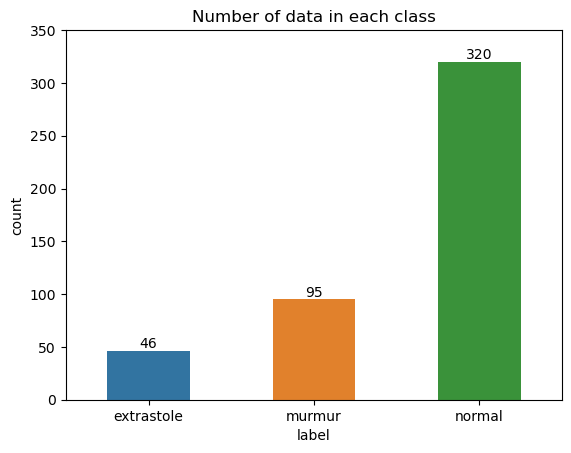

In [4]:
ax = sb.countplot(data_b_path, x='label', width=0.5)
ax.bar_label(ax.containers[0])

# plot number of dataset for each class
plt.title('Number of data in each class')
plt.ylim([0, 350])

- number of data in class **'normal'** (320) is a lot more than **'murmur'** (95) and **'extrastole'** (46). This may cause class imbalance when training the model later, if the dataset is not fed carefully. Later, we will over-sample minority classes during training.

Text(0, 0.5, 'amplitude')

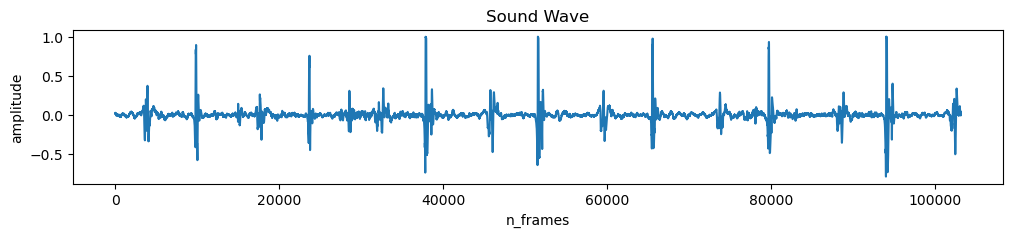

In [5]:
data_index = 0
fig, ax = plt.subplots(1,1,figsize=(12,2))
ax.plot(dataset.dataset[data_index])
ax.set_title('Sound Wave')
ax.set_xlabel('n_frames')
ax.set_ylabel('amplitude')

The graph above shows 1D array of sound wave collected using stethoscope. <br/>In theory, there will be 2 higher peak and 2 lower peak per 1 heart beat. Higher peaks correspond to S1 (mitral and tricuspid valve closure) and S2 (aortic and pulmonary valve closure). Lower peaks correspond to S3 and S4.

Some other general information are:
- sample rate is 22050 frame/second
- amplitude of graph are ~1.0 (no unit specified in the dataset documentation)
- data are varied in duration (from 0.4 s - 27.1 s) (see next plot)

#### ```Duration```

(0.0, 30.0)

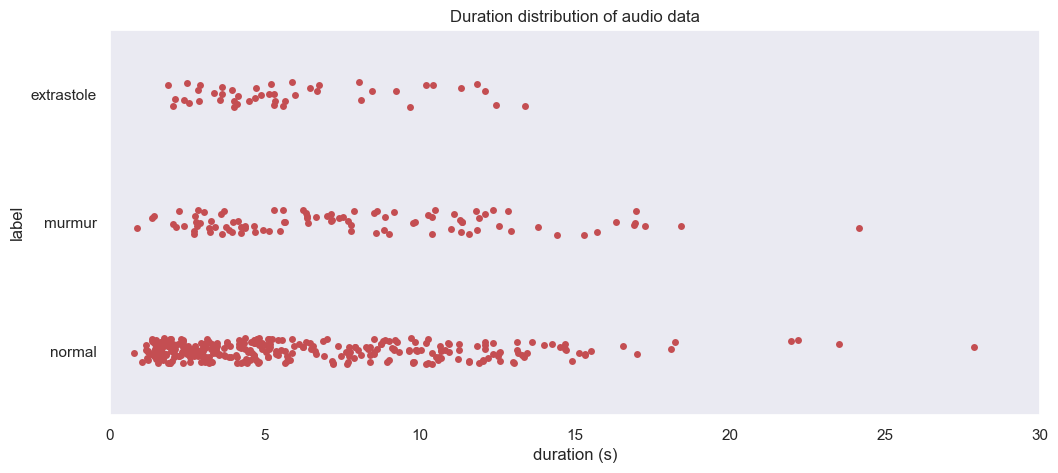

In [6]:
fig = plt.figure(figsize=(12,5))
fig.tight_layout(w_pad=3.0)
sb.set_theme(style="dark")
plt.title('Duration distribution of audio data')
sb.stripplot(dataset.metadata, x='duration', y='label', c= 'r')
plt.xlabel('duration (s)')
plt.xlim([0,30])

Since duration (length) of each data was not the same, we may need to add padding for time-dependent features before being able to input the model.

### 2. 1D wave form plot, Spectrum plot (frequency), and Short-time Fourier transform plot

/var/folders/mk/w2mwvrjn5sn9g2fty5rrgzd40000gn/T/ipykernel_57239/1770330476.py:11: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[i,1].set_xlim([0,4000])


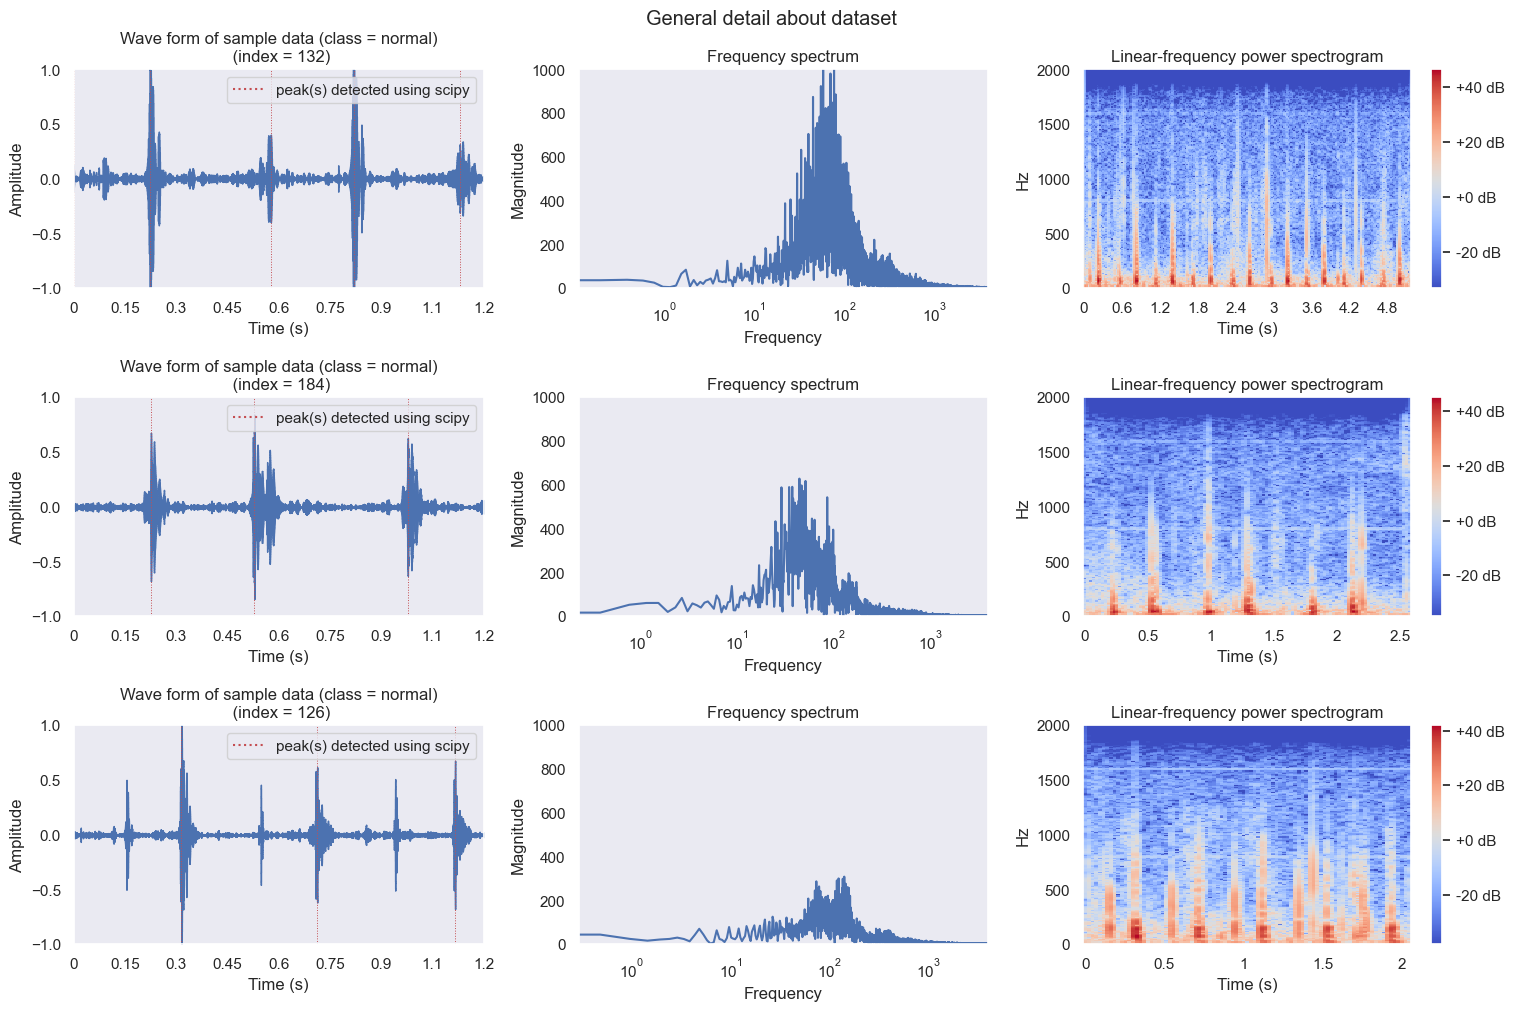

In [49]:
fig, axes = plt.subplots(3,3, figsize=(15,10))
fig.tight_layout(w_pad=3.0, h_pad=5.0)
fig.suptitle('General detail about dataset')

for i in range(3):
    index = np.random.randint(461)
    sb.set_theme(style="dark")
    plt.subplots_adjust(top=0.92)

    show_spectrum(dataset.dataset[index], 22050, ax=axes[i,1])
    axes[i,1].set_xlim([0,4000])

    # plot number of dataset for each class
    axes[i, 1].set_title('Frequency spectrum')
    axes[i, 1].set_ylim([0, 1000])

    # plot wave form and peak
    sound_flatten = ((dataset.dataset[index] > 0.05) + (dataset.dataset[index] < -0.05)) * dataset.dataset[index]
    peak_array, _ = scipy.signal.find_peaks(sound_flatten, 
                                            height=0.1, 
                                            distance=0.2*dataset.SR)
    dataset.show_wave(index, ax=axes[i, 0], flatten=False)
    label = dataset.metadata['label'][index]
    for eachpeak in peak_array:
        axes[i, 0].axvline(x = eachpeak/dataset.SR, color = 'r', 
                        ls=":", linewidth=0.7)
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].set_xlabel('Time (s)')
    dummy_line = axes[i, 0].plot([0,0.000001], [0, 0.00001], color='r', ls=':')
    axes[i, 0].set_xlim([0.0, 1.2])
    axes[i, 0].set_ylim([-1.0, 1.0])
    axes[i, 0].set_title(f'Wave form of sample data (class = {label})\n (index = {index})')
    axes[i, 0].legend(dummy_line, ["peak(s) detected using scipy"], loc='upper right')

    spectrogram = dataset.show_spec(index, ax=axes[i, 2], y_axis='linear', x_axis='time')
    fig.colorbar(spectrogram, format='%+2.0f dB')
    axes[i, 2].set_title('Linear-frequency power spectrogram')
    axes[i, 2].set_xlabel('Time (s)')
    axes[i ,2].set_ylim([0, 2000])

- Note:
    - dB shown in the graph is relative to mean of power (not relative to $10^{-12}$ watt per square metre).
    - We will not use sublabel data in our project.
- Notice: 
    - In the spectrogram (the leftmost figure), there are constant fringe ~0 dB on *Frequency~1000 Hz & ~1100 Hz*. This may be the static noise of the environment/device. We may have to denoise this constant frequency band before training the model.
    - Amplitude of each data is not the same, we may need to normalize it before training.

### 2. Beat per minute distribution across different class

- Beat per minute is calculated in function ```aproximate_bpm``` in ```utils.dataset```. <br/>
- The beats (peaks) are detected using ```scipy.signal.find_peaks``` then the intervals between each peak are used to calculate BPM. Then, the peak array was stored in ```self.metadata['peak-interval']``` and corresponding time for each peak in ```self.metadata['peak-interval-timer']```

In [8]:
dataset.metadata.head()

,dataset,fname,label,sublabel,bpm,peak-interval,peak-interval-timer,duration
0,b,set_b/extrastole__127_1306764300147_C2.wav,extrastole,NaN,96.235913,"[0.2686167800453515, 0.352562358276644, 0.2744...","[0.1781859410430839, 0.4468027210884354, 0.799...",4.676009
1,b,set_b/extrastole__128_1306344005749_A.wav,extrastole,NaN,90.943461,"[0.2494331065759637, 0.37750566893424037, 0.25...","[0.2770068027210884, 0.5264399092970522, 0.903...",9.236508
2,b,set_b/extrastole__130_1306347376079_D.wav,extrastole,NaN,112.422248,"[0.2529251700680272, 0.26702947845804986, 0.25...","[0.15156462585034014, 0.40448979591836737, 0.6...",4.002766
3,b,set_b/extrastole__134_1306428161797_C1.wav,extrastole,NaN,105.416460,"[0.3017233560090703, 0.28122448979591835, 0.30...","[0.07968253968253969, 0.38140589569161, 0.6626...",2.561270
4,b,set_b/extrastole__138_1306762146980_B.wav,extrastole,NaN,74.039667,"[0.28834467120181406, 0.3871201814058957, 0.29...","[0.3514285714285714, 0.6397732426303855, 1.026...",8.103764


Text(0.5, 0.98, 'Distribution of Beats Per Minute (BPM)')

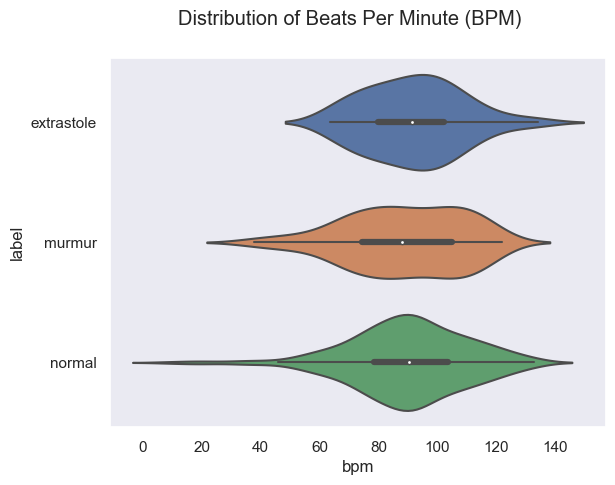

In [31]:
sb.violinplot(data=dataset.metadata, x="bpm", y="label")
plt.plot()

plt.suptitle('Distribution of Beats Per Minute (BPM)')

All 3 class have similar distribution in BPM. Hence, BPM alone may not be a good predictor for classify each heart desease.

#### 3. Noisiness of the some data

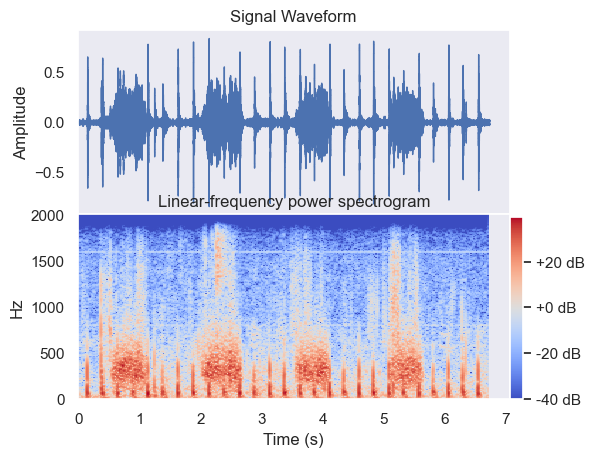

In [111]:
fig, axes = plt.subplots(2,1, sharex=True)
dataset.show_wave(idx=43, ax=axes[0])
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Signal Waveform')

spectrogram = dataset.show_spec(43, ax=axes[1], y_axis='linear', x_axis='time')
axes[1].set_title('Linear-frequency power spectrogram')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylim([0, 2000])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.8, 0.11, 0.02, 0.38])
fig.colorbar(spectrogram, format='%+2.0f dB', cax=cbar_ax)
plt.subplots_adjust(hspace=.0)

We also found that some data got noisy period as seen in graph above. The region was shown in both STFT and wave. However, only a few data have this characteristic, which happen uniformly for each class ```extrastole```. So, we assume it is a noisy data.

Detecting this region can be easily done in STFT domain using ```AvgPool``` and ```Thresholding```

In [127]:
a = torch.Tensor(dataset.stft[0])
a.size()

torch.Size([1025, 202])

In [181]:
import torch

noisy_data = []

for i in range(461):
    x = torch.Tensor(dataset.stft[i])[:100, :]
    x = x.view(1, 1, x.size(0), -1)
    # Average pool
    x = torch.nn.AvgPool2d(kernel_size=(9,9))(x)
    result = torch.max(x)
    # Thresholding 
    if (result > 50 + torch.min(x)):
        noisy_data.append(i)
print(f'index with noise : {noisy_data}')

index with noise : [13, 43, 54, 56, 58, 69, 77, 98, 104, 105, 314, 364, 377, 380, 393, 408, 412, 445, 446, 451]


Text(0.5, 1.0, 'index = 43 \n class = extrastole')

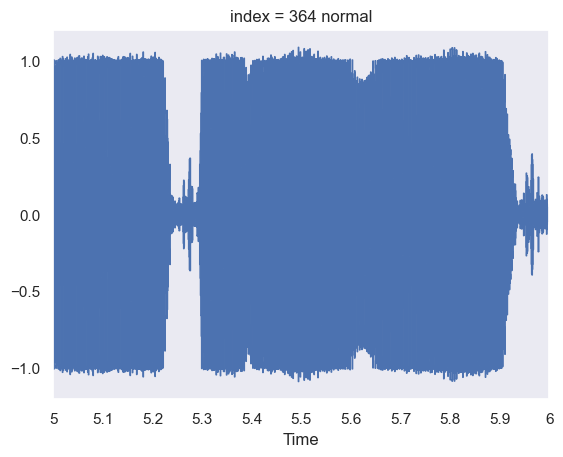

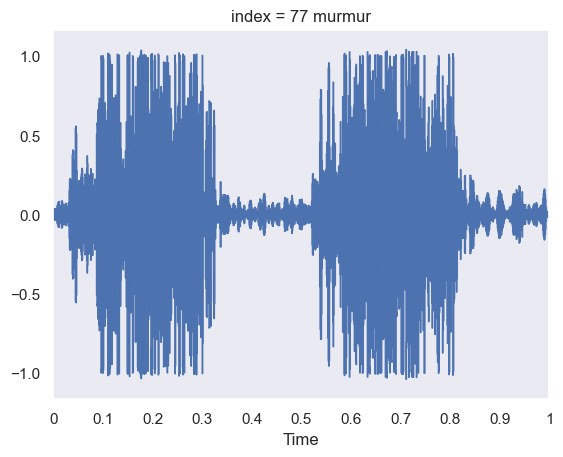

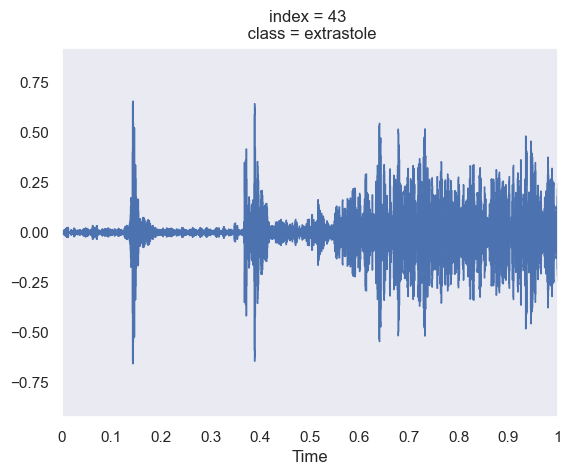

In [212]:
# Example of weird noisy data detected
fig, axes = plt.subplots(1,1, sharex=True)
dataset.show_wave(idx=364, ax=axes)
axes.set_xlim([5,6])
label = dataset.metadata['label'][364]
axes.set_title(f'index = 364 {label}')

fig, axes = plt.subplots(1,1, sharex=True)
dataset.show_wave(idx=77, ax=axes)
axes.set_xlim([0,1])
label = dataset.metadata['label'][77]
axes.set_title(f'index = 77 {label}')

fig, axes = plt.subplots(1,1, sharex=True)
dataset.show_wave(idx=43, ax=axes)
axes.set_xlim([0,1])
label = dataset.metadata['label'][43]
axes.set_title(f'index = 43 \n class = {label}')

After we plot every index detected, we found that ```index = [13, 54, 58, 69, 314, 377, 446, 451]``` have high magnitude, but does not exhibit this weird noise behavior. So, we will only exclude ```index = [43, 56, 77, 98, 104, 105, 364, 380, 393, 408, 412, 445]``` during training and testing.

#### 4. Structural changes in periodicity

```Assumption```: Since murmur and extrasystole cause irregularibility in heart beat, structural periodicity of graph over times will change.
<br/>
We will detect structural periodic changes of wave using ```Peridogram``` and ```Autocorrelation``` following [(Vlachos M., 2006)](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.66.6950&rep=rep1&type=pdf).

In [65]:
dataset.dataset[0]

array([ 0.02566082,  0.02831508,  0.02967718, ..., -0.00442724,
       -0.00407936,  0.        ], dtype=float32)

In [1]:
scipy.signal.periodogram(dataset.dataset[0])

NameError: name 'scipy' is not defined

### Denoise static frequency

In [63]:
def fft_denoiser(x, n_components, to_real=True):
    n = len(x)
    fft = np.fft.fft(x, n)
    PSD = fft * np.conj(fft) / n
    _mask = PSD > n_components
    fft = _mask * fft
    clean_data = np.fft.ifft(fft)
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

def stft_denoiser(wave, plot=False):
    noised_data = fft_denoiser(wave, 0.001)
    sos = scipy.signal.butter(1, 250, 'hp', fs=22050, output='sos')
    filtered_noised_data = scipy.signal.sosfilt(sos, noised_data)
    if plot:
        stft = librosa.amplitude_to_db(librosa.stft(wave))
        denoised_stft = librosa.amplitude_to_db(librosa.stft(wave-filtered_noised_data))

        fig, axes = plt.subplot_mosaic(
            [
                ["top row", "top row"],
                ["middle row", "middle row"],
                ["bottom left", "bottom right"],
                ["bottom left", "bottom right"],
            ]
        )
        plt.rcParams["figure.figsize"]=(12,10)
        fig.tight_layout(h_pad=1.)
        axes['top row'].plot(wave)
        axes['top row'].set_title('original signal')
        axes['top row'].set_xlabel('n_frames')
        axes['top row'].set_xlim([0,22050*2])
        axes['top row'].set_ylim([-0.5,0.5])
        axes['top row'].set_xticks([], color='w')
        axes['middle row'].plot(wave-filtered_noised_data)
        axes['middle row'].set_title('denoised signal')
        axes['middle row'].set_xlabel('n_frames')
        axes['middle row'].set_xlim([0,22050*2])
        axes['middle row'].set_ylim([-0.5,0.5])
        axes['middle row'].set_xticks([], color='w')
        axes['bottom left'].set_title('original signal in STFT')
        axes['bottom left'].imshow(stft)
        axes['bottom left'].set_ylim([0,200])
        axes['bottom right'].imshow(denoised_stft)
        axes['bottom right'].set_ylim([0,200])
        axes['bottom right'].set_title('denoised signal in STFT')
        plt.show()
    

/Users/nattapolchanpaisit/miniforge3/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


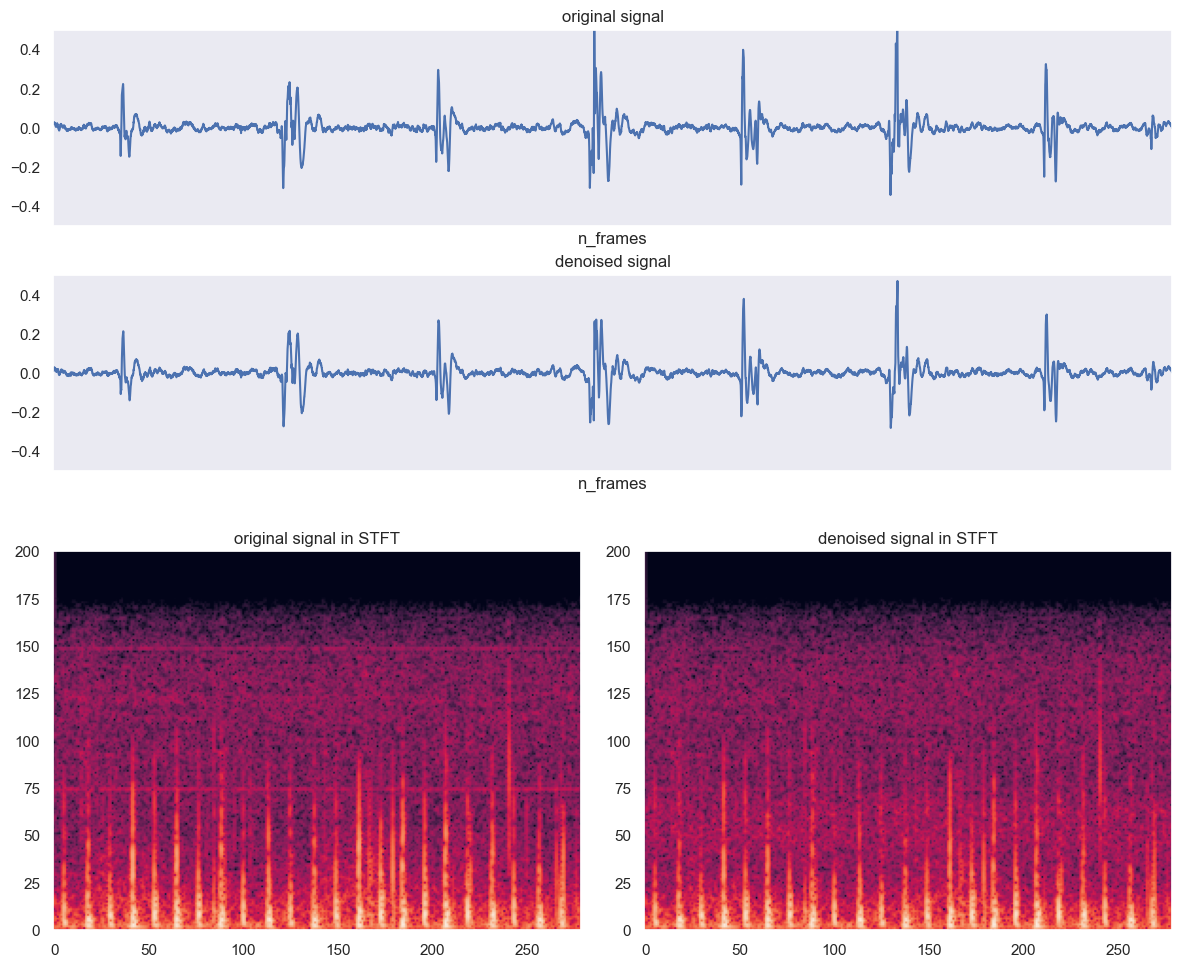

In [64]:
stft_denoiser(dataset.dataset[10], plot=True)